In [1]:
from torchvision import utils
from basic_fcn import *
from dataloader import *
from utils import *
import torchvision
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import time
import matplotlib.pyplot as plt


Ground truth


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted
(1, 1024, 2048)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


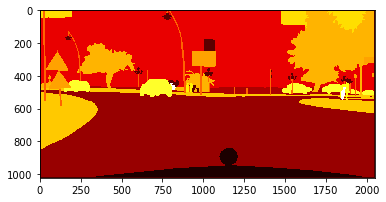

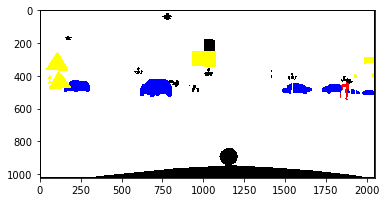

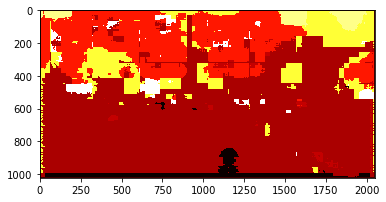

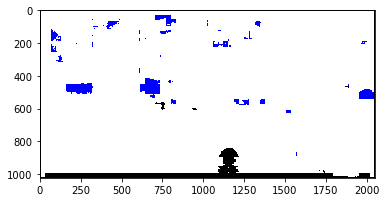

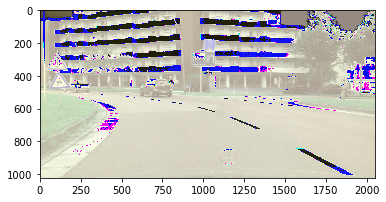

In [3]:
test_dataset = CityScapesDataset(csv_file='train.csv')
test_loader = DataLoader(dataset=test_dataset,
                          batch_size=1,
                          num_workers=1,
                          shuffle=False)

use_gpu = torch.cuda.is_available()
model = torch.load('best_model')
for iter, (X, tar, Y) in enumerate(test_loader):
    Y = Y.cpu().data.numpy()
    print("Ground truth")
    plt.imshow(Y[0], cmap='hot', interpolation='nearest')
    plt.figure()
    img = np.zeros((Y.shape[1],Y.shape[2],3))
    for ind in range(n_class):
        arg = np.argwhere(Y[0]==ind)
        img[arg[:,0],arg[:,1],0] = labels_classes[ind].color[0]
        img[arg[:,0],arg[:,1],1] = labels_classes[ind].color[1]
        img[arg[:,0],arg[:,1],2] = labels_classes[ind].color[2]
    plt.imshow(img)
    plt.figure()
    print("Predicted")
    pred = model(X.cuda())
    Y = pred.argmax(dim = 1)
    Y = Y.cpu().data.numpy()
    plt.imshow(Y[0], cmap='hot', interpolation='nearest')
    plt.figure()
    print(Y.shape)
    img = np.zeros((Y.shape[1],Y.shape[2],3))
    for ind in range(n_class):
        arg = np.argwhere(Y[0]==ind)
        img[arg[:,0],arg[:,1],0] = labels_classes[ind].color[0]
        img[arg[:,0],arg[:,1],1] = labels_classes[ind].color[1]
        img[arg[:,0],arg[:,1],2] = labels_classes[ind].color[2]
    plt.imshow(img)
    plt.figure()
    to_pil = torchvision.transforms.ToPILImage()
    img = to_pil(X[0])
    plt.imshow(img)
    break
#     if use_gpu:
#         X = X.cuda()
#     else:
#         X,tar= X.cpu()
    
    